# Use Augmented Random Search to Play BipedalWalker-v3

In [1]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import gym
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('BipedalWalker-v3')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

def clip_reward(reward):
    return np.clip(reward, -1., 1.)
reward_clipped_env = gym.wrappers.TransformReward(env, clip_reward)

00:08:42 [INFO] env: <BipedalWalker<BipedalWalker-v3>>
00:08:43 [INFO] action_space: Box(-1.0, 1.0, (4,), float32)
00:08:43 [INFO] observation_space: Box(-inf, inf, (24,), float32)
00:08:43 [INFO] reward_range: (-inf, inf)
00:08:43 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
00:08:43 [INFO] _max_episode_steps: 1600
00:08:43 [INFO] _elapsed_steps: None
00:08:43 [INFO] id: BipedalWalker-v3
00:08:43 [INFO] entry_point: gym.envs.box2d:BipedalWalker
00:08:43 [INFO] reward_threshold: 300
00:08:43 [INFO] nondeterministic: False
00:08:43 [INFO] max_episode_steps: 1600
00:08:43 [INFO] _kwargs: {}
00:08:43 [INFO] _env_name: BipedalWalker


In [3]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps

In [4]:
class ESAgent:
    def __init__(self, env=None, weights=None, bias=None):
        if weights is not None:
            self.weights = weights
        else:
            self.weights = np.zeros((env.observation_space.shape[0],
                    env.action_space.shape[0]))
        if bias is not None:
            self.bias = bias
        else:
            self.bias = np.zeros(env.action_space.shape[0])

    def reset(self, mode=None):
        pass

    def close(self):
        pass

    def step(self, observation, _reward, _done):
        action = np.matmul(observation, self.weights)
        return action

    def train(self, env, scale=0.06, learning_rate=0.09, population=16):
        weight_updates = np.zeros_like(self.weights)
        bias_updates = np.zeros_like(self.bias)
        for _ in range(population):
            weight_delta = scale * np.random.randn(*agent.weights.shape)
            bias_delta = scale * np.random.randn(*agent.bias.shape)
            pos_agent = ESAgent(weights=self.weights + weight_delta,
                    bias=self.bias + bias_delta)
            pos_reward, _ = play_episode(env, pos_agent)
            neg_agent = ESAgent(weights=self.weights - weight_delta,
                    bias=self.bias - bias_delta)
            neg_reward, _ = play_episode(env, neg_agent)
            weight_updates += (pos_reward - neg_reward) * weight_delta
            bias_updates += (pos_reward - neg_reward) * bias_delta
        self.weights += learning_rate * weight_updates / population
        self.bias += learning_rate * bias_updates / population


agent = ESAgent(env=env)

00:08:43 [INFO] ==== train & evaluate ====
00:08:55 [DEBUG] evaluate generation 0: reward = -92.21, steps = 112
00:09:05 [DEBUG] evaluate generation 1: reward = -92.84, steps = 98
00:09:12 [DEBUG] evaluate generation 2: reward = -95.17, steps = 67
00:09:15 [DEBUG] evaluate generation 3: reward = -95.99, steps = 79
00:09:25 [DEBUG] evaluate generation 4: reward = -93.12, steps = 85
00:09:30 [DEBUG] evaluate generation 5: reward = -93.49, steps = 86
00:09:40 [DEBUG] evaluate generation 6: reward = -95.27, steps = 75
00:09:48 [DEBUG] evaluate generation 7: reward = -97.63, steps = 56
00:09:54 [DEBUG] evaluate generation 8: reward = -98.29, steps = 57
00:09:57 [DEBUG] evaluate generation 9: reward = -95.33, steps = 66
00:10:01 [DEBUG] evaluate generation 10: reward = -98.50, steps = 61
00:10:02 [DEBUG] evaluate generation 11: reward = -97.95, steps = 65
00:10:06 [DEBUG] evaluate generation 12: reward = -96.33, steps = 71
00:10:08 [DEBUG] evaluate generation 13: reward = -101.46, steps = 56

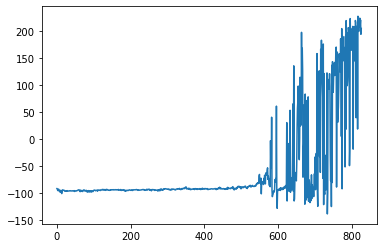

In [5]:
logging.info('==== train & evaluate ====')
episode_rewards = []
for generation in itertools.count():
    agent.train(reward_clipped_env)
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('evaluate generation %d: reward = %.2f, steps = %d',
            generation, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > 200.:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))